In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# !pip install polars

In [3]:
from typing import List
import numpy as np

import json
import copy
import load_data
from pprint import pprint
import matplotlib.pyplot as plt
import polars as pl
import experiment_1 as experiment

from collections import defaultdict
import jax.numpy as jnp
import jax.tree_util as jtu
import jax

from load_data import get_timestep, compute_reaction_time, EpisodeData
from load_data import render_episode, get_task_object, object_idx_to_name, success_fn, get_task_room, create_maps
from load_data import filter_episodes


No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
Compiling jax environment functions.
	time: 1.129429817199707
Compiling multi-render function.
	time: 0.0602569580078125


In [14]:
# file_path = "test_data.json"
file_path = 'data/data_user=64_name=r0-v2_exp=1_debug=1.json'
with open(file_path, 'r') as f:
        data_dicts = json.load(f)

In [15]:
finished = data_dicts.pop(-1)
finished

{'finished': True}

EVERY SINGLE TIMESTEP of EVERY EPISODE is all in ONE GIANT list

we want to separate them out. 

I'll separate them out into episodes


In [16]:
# before processing compute times of exp
# sum each image-action pair
start_end = load_data.time_diff(data_dicts[0]['image_seen_time'], data_dicts[-1]['action_taken_time'])/1000
print(f"Total seconds from 1st time-step to last action: {start_end:.2f}")

# sum each image-action pair
total_timestep_times = sum([load_data.time_diff(d['image_seen_time'], d['action_taken_time']) for d in data_dicts])/1000
print(f"Total seconds across image-action pairs: {total_timestep_times:.2f}")


Total seconds from 1st time-step to last action: 22.32
Total seconds across image-action pairs: 20.06


In [17]:
# list of every individual time-step
# remove all blocks that are "practice"
data_dicts = [row for row in data_dicts if not 'practice' in row['metadata']['block_metadata']['desc']]


# Below I'll print out values of a random datapoint

In [18]:
# 1 timestep datum
datum = data_dicts[1]
pprint(list(datum.keys()))

['id',
 'session_id',
 'stage_idx',
 'image_seen_time',
 'action_taken_time',
 'computer_interaction',
 'action_name',
 'action_idx',
 'user_data',
 'metadata',
 'data']


In [19]:
for key in [
    'id',            # time-step idx. global
     'session_id',   # browser session id
     'stage_idx',
     'image_seen_time',
     'action_taken_time',
     'computer_interaction',
     'action_name',
     'action_idx']:
    print(key, ":", datum[key])
    

id : 2
session_id : 9a2197ba-4e59-4059-b12b-5a864794787d
stage_idx : 1
image_seen_time : 2024-09-18T23:44:54.881Z
action_taken_time : 2024-09-18T23:44:56.786Z
computer_interaction : ArrowUp
action_name : up
action_idx : 3


In [20]:
datum['metadata'] # remember, this is for the VERY FIRST timestep of this episode

{'desc': 'training',
 'maze': 'maze3',
 'eval': False,
 'block_metadata': {'manipulation': 1,
  'desc': 'shortcut',
  'long': 'A shortcut is introduced',
  'groups': [[29, 13], [43, 3], [27, 46]],
  'char2idx': {'A': 29, 'B': 13, 'C': 43, 'D': 3, 'E': 27, 'F': 46},
  'idx': 0},
 'nsteps': 2,
 'episode_idx': 1,
 'nsuccesses': 0}

In [21]:
datum['user_data']

{'user_id': 64, 'age': 10, 'sex': 'Male'}

In [22]:
# we will use this to fill in columns of a pandas dataframe
load_data.get_block_stage_description(data_dicts[-1])

{'stage': "'not obvious' shortcut",
 'block': 'shortcut',
 'manipulation': 1,
 'episode_idx': 1,
 'eval': True}

In [13]:

datum = data_dicts[0]
action_taken: int = datum['action_idx']
image_seen_time: str = datum['image_seen_time']
action_taken_time: str = datum['action_taken_time']
reaction_time: float = load_data.compute_reaction_time(datum)

print(f"Reaction time: {reaction_time:.2f} milliseconds")

Reaction time: 1292.00 milliseconds


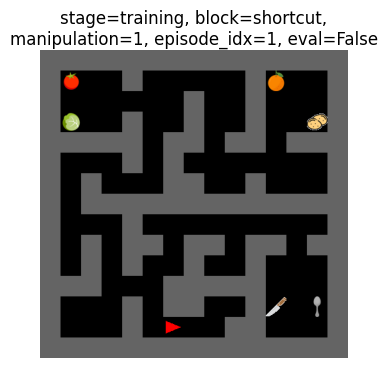

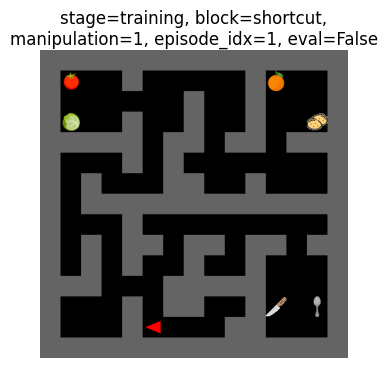

In [26]:
# let's just print out the first few time-step to see what they look like
keys = set()
nidx = 2
# nidx = len(data_dicts)
for idx in range(nidx):
    datum = data_dicts[idx]
    # get the information describing block x stage pairs. you can edit this function if you want
    info = load_data.get_block_stage_description(datum)
    title = load_data.dict_to_string(info)
    if not title in keys:
        print("="*100)
        keys.add(title)
    
    timestep = load_data.get_timestep(datum)
    image = experiment.render_fn(timestep)

    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, wrap=True)
    plt.show()
    

# Now I'll actually process the data

In [23]:
def separate_data_by_block_stage(data: List[dict]):
    """This function will group episodes by the values from get_block_stage_description

    The input i
    So for example, each episode with {'stage': "'not obvious' shortcut",
     'block': 'shortcut',
     'manipulation': 1,
     'episode_idx': 1,
     'eval': True}
     with go into its own list.
    """
    grouped_data = defaultdict(list)
    episode_idx = -1
    keys = set()
    infos = dict()
    # first group all of the data based on which (stage, block) its in
    for datum in data:
        info = load_data.get_block_stage_description(datum)
        key = load_data.dict_to_string(info)
        if not key in keys:
            episode_idx += 1
            keys.add(key)
        info['global_episode_idx'] = episode_idx
        
        updated_key = load_data.dict_to_string(info)
        grouped_data[updated_key].append(datum)
        infos[updated_key] = info
    return grouped_data, infos

gds, gd_infos = separate_data_by_block_stage(data_dicts)
# gd_infos

In [24]:

def make_episode_data(data: List[dict]):
    """This groups all of the data by block/stage information and prepares 
        (1) a list of EpisodeData objects per block/stage
        (2) a dataframe which summarizes all episode information.

    The dataframe can be used to get indices into the list of EpisodeData for further computation.
    """
    gds, gd_infos = separate_data_by_block_stage(data)

    episode_data = [None]*len(gds.keys())
    episode_info = [None]*len(gds.keys())
    for key in gds.keys():
        red = raw_episode_data = gds[key]
        # get actions

        actions = jnp.asarray([datum['action_idx'] for datum in red])

        # collect timesteps
        timesteps = [get_timestep(datum) for datum in red]
        
        # combine them into trajectory
        timesteps = jtu.tree_map(
                lambda *v: jnp.stack(v), *timesteps)

        positions = timesteps.state.agent_pos

        reaction_times = [compute_reaction_time(datum) for datum in red]
        reaction_times = jnp.asarray(reaction_times)

        episode_idx = gd_infos[key]['global_episode_idx']
        episode_data[episode_idx] = EpisodeData(
            actions=actions,
            positions=positions,
            reaction_times=reaction_times,
            timesteps=timesteps,
            
        )

        ######################
        # THIS IS WHERE YOU'LL WANT TO INSERT OTHER EPISODE LEVEL INFO TO TRACK IN DATAFRAME!!!
        ######################
        info = copy.deepcopy(gd_infos[key])
        info.update(
            task=get_task_object(timesteps),
            room=get_task_room(timesteps),
        )
        datum0 = red[0]
        # add in user information to dataframe
        info.update(datum0['user_data'])
        
        episode_info[episode_idx] = info

    episode_info = pl.DataFrame(episode_info)
    return episode_data, episode_info
    
# NOTE: manipulation room is __always__ room 0, even if task objects differ
all_episode_data, all_episode_info = make_episode_data(data_dicts)
all_episode_info.head()

stage,block,manipulation,episode_idx,eval,global_episode_idx,task,room,user_id,age,sex
str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
"""training""","""shortcut""",1,1,false,0,27,2,64,10,"""Male"""
"""'not obvious' shortcut""","""shortcut""",1,1,true,1,13,0,64,10,"""Male"""


---------- 0


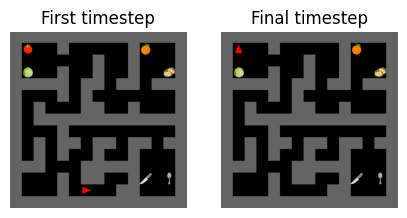

Task object idx: 27
Task object: tomato
Eval? False
Success? True
---------- 1


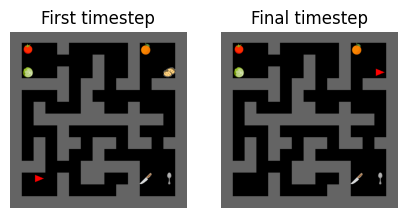

Task object idx: 13
Task object: potato
Eval? True
Success? True


In [25]:
# Here I'll just print some useful information for a single single episode
nepisodes = 2
idxs = range(nepisodes)
idxs = range(len(all_episode_data))
# idxs = [len(all_episode_data)-1, len(all_episode_data)-2]
for idx in idxs:
    print('-'*10, idx)
    episode_data = all_episode_data[idx]
    episode_info = all_episode_info[idx]

    # Visualize 1st and last images of episode
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    start = render_episode(episode_data.timesteps, t=0)
    end = render_episode(episode_data.timesteps, t=-1)
    axs[0].imshow(start)
    axs[0].set_title("First timestep")
    axs[0].axis('off')
    
    axs[1].imshow(end)
    axs[1].set_title("Final timestep")
    axs[1].axis('off')
    plt.show()

    # Get the task object of the epside and print its name
    object_idx = get_task_object(episode_data.timesteps)
    object_name = object_idx_to_name(object_idx)
    print("Task object idx:", object_idx)
    print("Task object:", object_name)

    print("Eval?", episode_info['eval'].item())
    
    print("Success?", success_fn(episode_data.timesteps))


# Example aggregating information

In [20]:
all_episode_info.head()

stage,block,manipulation,episode_idx,eval,global_episode_idx,task,room,user_id,age,sex
str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
"""training""","""probing for planning near goal""",4,1,false,0,43,1,43,45,"""Male"""
"""training""","""probing for planning near goal""",4,2,false,1,29,0,43,45,"""Male"""
"""off-task object regular""","""probing for planning near goal""",4,1,true,2,13,0,43,45,"""Male"""
"""off-task object flipped""","""probing for planning near goal""",4,1,true,3,13,0,43,45,"""Male"""
"""training""","""shortcut""",1,1,false,4,43,1,43,45,"""Male"""


In [21]:
# Compute success rate mean and std

def success_mean_std(episode_data_list: List[EpisodeData]):
    successes = [success_fn(episode_data.timesteps) for episode_data in episode_data_list]
    return np.mean(successes), np.std(successes)

# can given in filters as keyword arguments after list of episode_data and episode_info dataframe
episodes = filter_episodes(all_episode_data, all_episode_info, manipulation=1, eval=False)
mean, std = success_mean_std(episodes)

print("mean:", mean)
print("std:", std)

mean: 1.0
std: 0.0


In [22]:
# let's look at the overlap of a train/test example? using manipulation=1
train_episodes = filter_episodes(all_episode_data, all_episode_info, manipulation=1, eval=False, task=29, room=0)

eval_episodes = filter_episodes(all_episode_data, all_episode_info, manipulation=1, eval=True, stage="'not obvious' shortcut", room=0)
len(train_episodes), len(eval_episodes)

(1, 1)

In [23]:
# [13, 13]
train_map = create_maps(train_episodes).sum(0)  # sum over all episodes
eval_map = create_maps(eval_episodes).sum(0)

train_map, "", eval_map

(array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 '',
 array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1

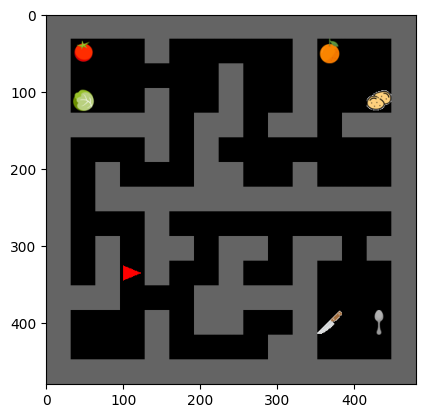

In [24]:
# lets plot the image just to make sure we know what we're working with
plt.imshow(render_episode(train_episodes[0].timesteps))

In [25]:
# below is the path taken
overlap = load_data.overlap(train_map, eval_map)
overlap.mean()

np.float64(0.9375)

In [26]:
# okay, now let look at the overlap when the map is different? using manipulation=2
other_train_episodes = filter_episodes(all_episode_data, all_episode_info, manipulation=2)
other_train_map = create_maps(other_train_episodes).sum(0)  # sum over all episodes

overlap = load_data.overlap(other_train_map, eval_map)
overlap.mean()

np.float64(0.5892857142857143)